In [12]:
import sys
!{sys.executable} -m pip install xgboost
!pip3 install imblearn --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --user
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, precision_score, recall_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE as sm
from imblearn.over_sampling import RandomOverSampler
from imblearn import under_sampling

from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn import preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from scipy.stats import reciprocal, uniform
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
#from skopt import BayesSearchCV
from scipy.stats import randint as sp_randint
#import missingno as mso
from sklearn.metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import itertools
!pip install lightgbm
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier


# Data Loading

In [13]:
app_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')

# Data Merging

**Both Datasets will be merged to link every user with his/her credit history**

In [14]:
#sorting IDs
app_df = app_df.sort_values('ID')
credit_df = credit_df.sort_values('ID')
#Map the status to bad or good
credit_df['STATUS_BINARY'] = credit_df['STATUS']
credit_df = credit_df.replace({'STATUS_BINARY' :{'C' : 'Good','X' : 'Good','0' : 'Bad', '1' : 'Bad','2' : 'Bad','3' : 'Bad','4' : 'Bad','5' : 'Bad'}})
result_df = credit_df.value_counts(subset=['ID', 'STATUS_BINARY']).unstack(fill_value=0).reset_index()
#decide the user is good or bad based on his/her history majority
result_df.loc[(result_df['Good'] / result_df['Bad'] >= 1), 'Status'] = 1
result_df.loc[(result_df['Good'] / result_df['Bad'] < 1 ), 'Status'] = 0
result_df['Status'] = result_df['Status'].astype(int)
df = app_df.merge(result_df, how='inner', on=['ID'])
#define the rate of good debts for each user
df['rate'] = (df['Good']+0.1) / (df['Bad']+0.1)
df.drop(['Good','Bad'],axis=1,inplace = True);
#Renaming columns to more friendly names
df.columns = ['ID', 'Gender', 'Car', 'Realty', 'Children', 'Income', 'Income_Type',
                        'Education_Type', 'Family_Status', 'Housing_Type',  'Age', 'Years_Experience' , 'Mobile_Phone', 'Work_Phone', 
                        'Phone', 'Email', 'Job_Title', 'Total_Family' , 'Status','rate']
df.head(5)

,ID,Gender,Car,Realty,Children,Income,Income_Type,Education_Type,Family_Status,Housing_Type,Age,Years_Experience,Mobile_Phone,Work_Phone,Phone,Email,Job_Title,Total_Family,Status,rate
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,6.714286
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,6.238095
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1,3.253521
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,1.476190
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,51.000000


# EDA

**How many good and bad history users ?**

<AxesSubplot:ylabel='Status'>

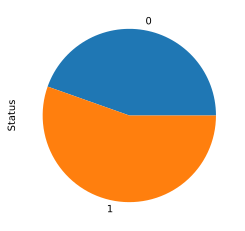

In [15]:
df.groupby('Status')['Status'].count().plot(kind='pie', y='Status')

**what is the majority gender of users ?**

<AxesSubplot:ylabel='Gender'>

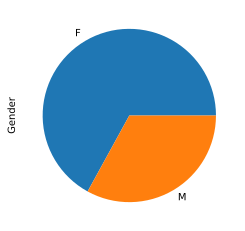

In [16]:
df.groupby('Gender')['Gender'].count().plot(kind='pie', y='Gender')

<AxesSubplot:xlabel='Income_Type'>

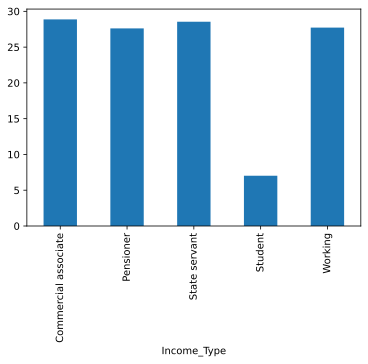

In [17]:
# Features effect on the decision and comparison with the rate
df.groupby('Income_Type')['rate'].mean().plot(kind = 'bar')

<AxesSubplot:xlabel='Family_Status'>

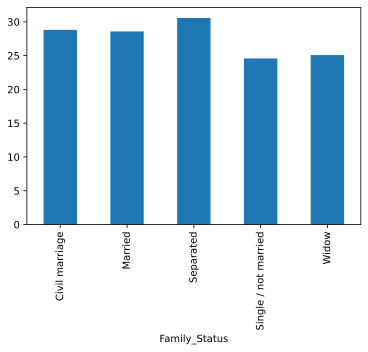

In [18]:
df.groupby('Family_Status')['rate'].mean().plot(kind = 'bar')

**Single has bad rate compared to married**

<AxesSubplot:xlabel='Car'>

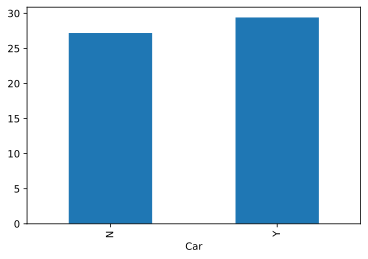

In [19]:
df.groupby('Car')['rate'].mean().plot(kind = 'bar')

**Users with cars have slightly better rates**

<AxesSubplot:xlabel='Realty'>

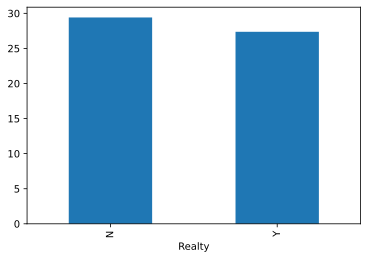

In [20]:
df.groupby('Realty')['rate'].mean().plot(kind = 'bar')

<AxesSubplot:xlabel='Total_Family'>

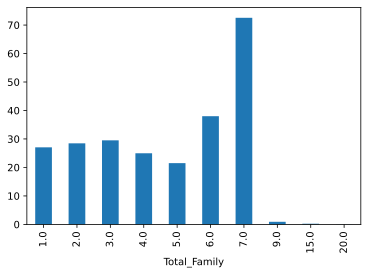

In [21]:
df.groupby('Total_Family')['rate'].mean().plot(kind = 'bar')

# Features distribution

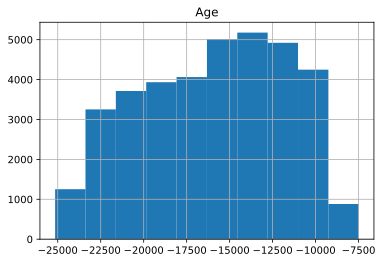

In [22]:
df.hist(column='Age');

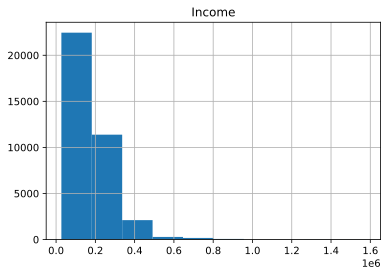

In [23]:
df.hist(column='Income');

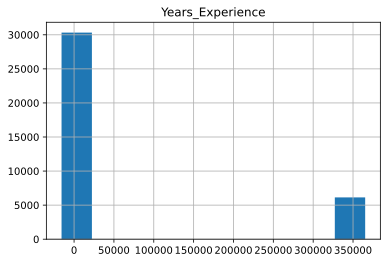

In [24]:
df.hist(column='Years_Experience');

**Some features have skewed distribution so the features will be normalize in next step**

**Corelation between features**

<AxesSubplot:>

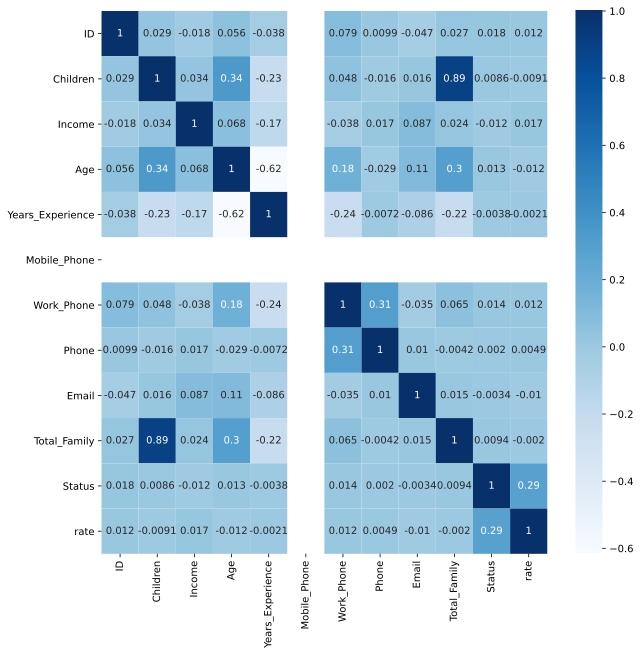

In [25]:
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, cmap="Blues", annot=True)

**Based on Corr Heatmap**

**Removing children (beacase high correlation with total_family)**

**Removing remove Mobile_phone**

In [26]:
df.drop(['Children','Mobile_Phone'],axis=1,inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                36457 non-null  int64  
 1   Gender            36457 non-null  object 
 2   Car               36457 non-null  object 
 3   Realty            36457 non-null  object 
 4   Income            36457 non-null  float64
 5   Income_Type       36457 non-null  object 
 6   Education_Type    36457 non-null  object 
 7   Family_Status     36457 non-null  object 
 8   Housing_Type      36457 non-null  object 
 9   Age               36457 non-null  int64  
 10  Years_Experience  36457 non-null  int64  
 11  Work_Phone        36457 non-null  int64  
 12  Phone             36457 non-null  int64  
 13  Email             36457 non-null  int64  
 14  Job_Title         25134 non-null  object 
 15  Total_Family      36457 non-null  float64
 16  Status            36457 non-null  int32 

<AxesSubplot:>

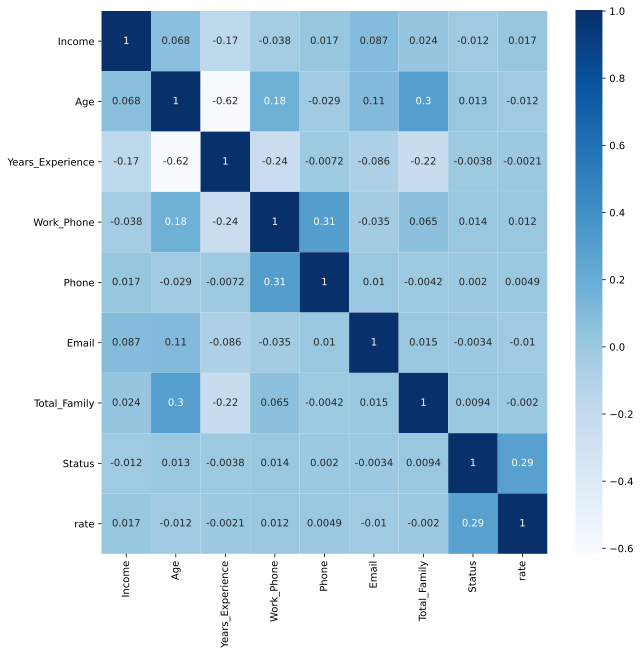

In [28]:
corr = df.drop('ID',axis=1).corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, cmap="Blues", annot=True)

# (Preprocessing)

# Handling missing values

In [29]:
df.isna().sum()

ID                      0
Gender                  0
Car                     0
Realty                  0
Income                  0
Income_Type             0
Education_Type          0
Family_Status           0
Housing_Type            0
Age                     0
Years_Experience        0
Work_Phone              0
Phone                   0
Email                   0
Job_Title           11323
Total_Family            0
Status                  0
rate                    0
dtype: int64

In [30]:
df = df.dropna()

In [31]:
# Handling Numerical values
#Convert  age and YOE to year format
df['Age'] = df['Age']/(-1*365)
df['Years_Experience'] = df['Years_Experience']/(-1*365)
df.head(5)

,ID,Gender,Car,Realty,Income,Income_Type,Education_Type,Family_Status,Housing_Type,Age,Years_Experience,Work_Phone,Phone,Email,Job_Title,Total_Family,Status,rate
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,58.832877,3.106849,0,0,0,Security staff,2.0,1,3.253521
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,0,1,1,Sales staff,1.0,1,1.476190
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,0,1,1,Sales staff,1.0,1,51.000000
5,5008810,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,0,1,1,Sales staff,1.0,1,3.459016
6,5008811,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.356164,8.358904,0,1,1,Sales staff,1.0,1,5.426230


In [32]:
# Handling Categorical Valus, Label Encoding
Cat_features = ['Realty', 'Gender','Car','Income_Type','Education_Type','Family_Status','Housing_Type','Job_Title']

for col in Cat_features:
    print(df[col].unique())
    
df.info()

['Y' 'N']
['M' 'F']
['Y' 'N']
['Working' 'Commercial associate' 'State servant' 'Student' 'Pensioner']
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']
['House / apartment' 'Rented apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
['Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Private service staff' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 2 to 36456
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                25134 non-null  int64  
 1   Gender            25134 non-null  object 
 2   Car    

In [33]:
le = preprocessing.LabelEncoder()

for col in Cat_features:
    df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25134 entries, 2 to 36456
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                25134 non-null  int64  
 1   Gender            25134 non-null  int32  
 2   Car               25134 non-null  int32  
 3   Realty            25134 non-null  int32  
 4   Income            25134 non-null  float64
 5   Income_Type       25134 non-null  int32  
 6   Education_Type    25134 non-null  int32  
 7   Family_Status     25134 non-null  int32  
 8   Housing_Type      25134 non-null  int32  
 9   Age               25134 non-null  float64
 10  Years_Experience  25134 non-null  float64
 11  Work_Phone        25134 non-null  int64  
 12  Phone             25134 non-null  int64  
 13  Email             25134 non-null  int64  
 14  Job_Title         25134 non-null  int32  
 15  Total_Family      25134 non-null  float64
 16  Status            25134 non-null  int32 

In [34]:
#Final Data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,25134.0,5.078838e+06,41941.018788,5.008806e+06,5.042228e+06,5.079004e+06,5.115604e+06,5.150487e+06
Gender,25134.0,3.781332e-01,0.484931,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Car,25134.0,4.183974e-01,0.493306,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
Realty,25134.0,6.549296e-01,0.475401,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Income,25134.0,1.948339e+05,104510.987243,2.700000e+04,1.350000e+05,1.800000e+05,2.250000e+05,1.575000e+06
Income_Type,25134.0,2.681825e+00,1.773317,0.000000e+00,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
Education_Type,25134.0,3.060038e+00,1.358220,0.000000e+00,1.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
Family_Status,25134.0,1.316862e+00,0.893762,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00
Housing_Type,25134.0,1.322074e+00,1.016785,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
Age,25134.0,4.053161e+01,9.553342,2.051781e+01,3.277808e+01,3.985479e+01,4.777534e+01,6.742740e+01


In [35]:
#Train Test Split
X = df.drop(['ID','Status'],axis = 1)
y = df['Status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

In [36]:
#Oversampling
balanced = under_sampling.NearMiss()
X_res, y_res = balanced.fit_resample(X, y)
X_train, y_train = balanced.fit_resample(X,y)

In [37]:
#Transformation
power = PowerTransformer(method='yeo-johnson')
X_train = power.fit_transform(X_train)
X_val = power.fit_transform(X_val)

In [38]:
#Scaling
normalizer = preprocessing.StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.fit_transform(X_val)

# Machine learning Algorithms Below

In [39]:
#RandomForest Classifier
model = RandomForestClassifier(random_state = 0)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))

Accuracy =  0.921623234533519
F1 =  0.9222573007103394


In [40]:
#XGB Classsifier
model =  XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))

print(classification_report(y_val, y_predict))

Accuracy =  0.921623234533519
F1 =  0.9222573007103394
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2296
           1       1.00      0.86      0.92      2731

    accuracy                           0.92      5027
   macro avg       0.93      0.93      0.92      5027
weighted avg       0.93      0.92      0.92      5027



In [46]:
#SVM Classifier
model = SVC(C=1,gamma = 0.001)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))

Accuracy =  0.936542669584245
F1 =  0.9379739451681898


In [45]:
#MLP Classifier algorithm
model = MLPClassifier(verbose = 0 , max_iter = 46 , random_state = 0)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
print("Accuracy = " , accuracy_score(y_val, y_predict))
print("F1 = " , f1_score(y_val, y_predict))

Accuracy =  0.9281877859558385
F1 =  0.9292295628308175


               precision    recall  f1-score   support

Non-Predicted       0.87      1.00      0.93      2296
    Predicted       1.00      0.88      0.93      2731

     accuracy                           0.93      5027
    macro avg       0.94      0.94      0.93      5027
 weighted avg       0.94      0.93      0.93      5027

Accuracy Score is 0.93256
      0     1
0  2296     0
1   339  2392


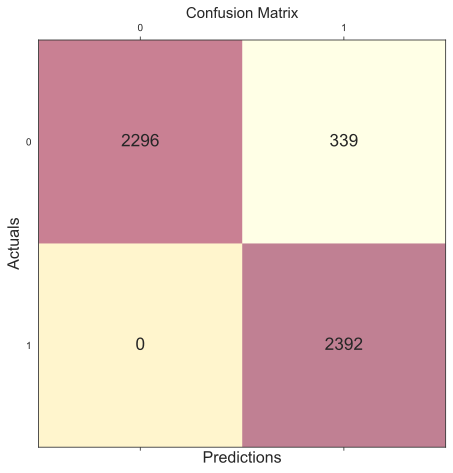

In [49]:
#logistics regression
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train, y_train)
y_predict = model.predict(X_val)
labels = ['Non-Predicted', 'Predicted']
print(classification_report(y_val, y_predict, target_names=labels))

print('Accuracy Score is {:.5}'.format(accuracy_score(y_val, y_predict)))
print(pd.DataFrame(confusion_matrix(y_val,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
mat_con = (confusion_matrix(y_val, y_predict,))


# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m,y=n,s=mat_con[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

Transaction Number x_train dataset:  (22324, 16)
Transaction Number y_train dataset:  (22324,)
Transaction Number x_test dataset:  (5027, 16)
Transaction Number y_test dataset:  (5027,)
Before OverSampling, counts of label '1': 11162
Before OverSampling, counts of label '0': 11162 

After OverSampling, the shape of train_x: (22324, 16)
After OverSampling, the shape of train_y: (22324,) 

After OverSampling, counts of label '1', %: 50.0
After OverSampling, counts of label '0', %: 50.0


<AxesSubplot:ylabel='count'>

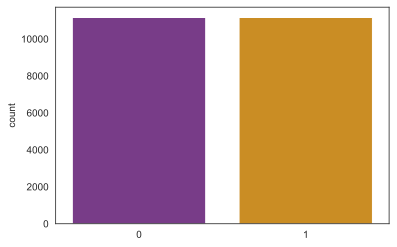

In [50]:
#improving Accuracy with Smote
print("Transaction Number x_train dataset: ", X_train.shape)
print("Transaction Number y_train dataset: ", y_train.shape)
print("Transaction Number x_test dataset: ", X_val.shape)
print("Transaction Number y_test dataset: ", y_val.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
x_train_s, y_train_s = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_x: {}'.format(x_train_s.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_s.shape))

print("After OverSampling, counts of label '1', %: {}".format(sum(y_train_s==1)/len(y_train_s)*100.0,2))
print("After OverSampling, counts of label '0', %: {}".format(sum(y_train_s==0)/len(y_train_s)*100.0,2))

sns.countplot(x=y_train_s, data=df, palette='CMRmap')

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2296
           1       1.00      0.87      0.93      2731

    accuracy                           0.93      5027
   macro avg       0.93      0.94      0.93      5027
weighted avg       0.94      0.93      0.93      5027



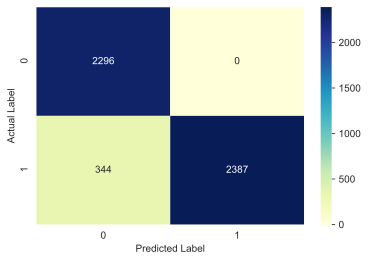

In [51]:
#after smote

logreg = LogisticRegression()
logreg.fit(x_train_s, y_train_s)
y_pred = logreg.predict(X_val)
cnf_matrix = confusion_matrix(y_val, y_pred)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print(classification_report(y_val, y_pred))

Text(0.5, 1.0, 'Precision Recall Curve')

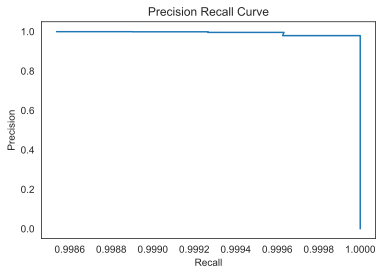

In [52]:
#Precision Curve
y_pred_prob = logreg.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2296
           1       1.00      0.86      0.92      2731

    accuracy                           0.92      5027
   macro avg       0.93      0.93      0.92      5027
weighted avg       0.93      0.92      0.92      5027



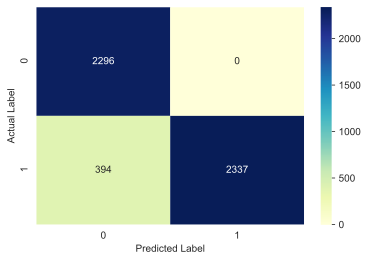

In [53]:
#Random Forest Classifier with SMOTE
rand_f = rfc(n_estimators=1000, min_samples_split=10, min_samples_leaf=1,
           max_features='auto', max_leaf_nodes=None,
           oob_score=True, n_jobs=-1, random_state=1)
rand_f.fit(x_train_s, y_train_s)
y_pred = rand_f.predict(X_val)

cnf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print(classification_report(y_val, y_pred))


Text(0.5, 1.0, 'Precision Recall Curve')

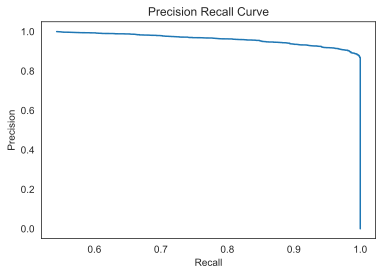

In [54]:
y_pred_prob = rand_f.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

Accuracy Score is 0.92162
      0     1
0  2296     0
1   394  2337


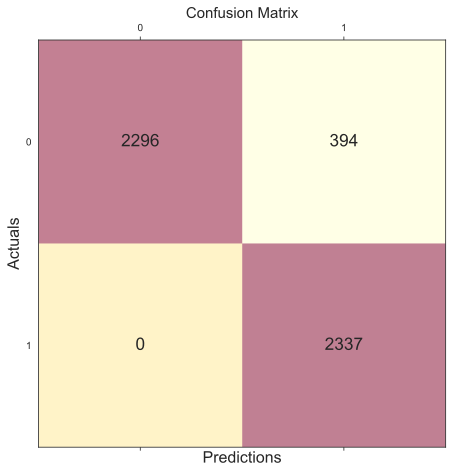

In [55]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_val, y_predict)))
print(pd.DataFrame(confusion_matrix(y_val,y_predict)))

mat_con = (confusion_matrix(y_val, y_predict,))

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m,y=n,s=mat_con[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

Accuracy Score is 0.92162
      0     1
0  2296     0
1   394  2337


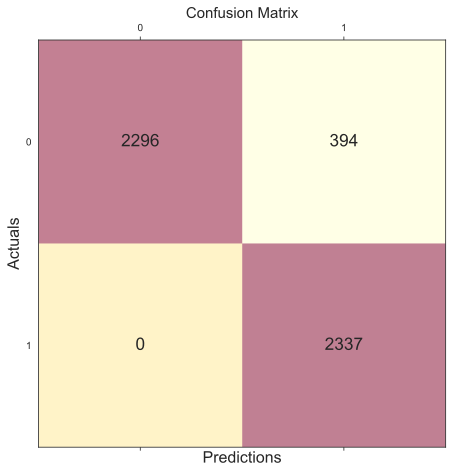

In [56]:
#RandomForest
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_val)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_val, y_predict)))
print(pd.DataFrame(confusion_matrix(y_val,y_predict)))

mat_con = (confusion_matrix(y_val, y_predict,))

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m,y=n,s=mat_con[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

Feature importance ranking


1.Total_Family(0.980314)
2.Housing_Type(0.004528)
3.Age(0.004350)
4.Realty(0.003028)
5.Email(0.001790)
6.Job_Title(0.000948)
7.Education_Type(0.000777)
8.Income_Type(0.000718)
9.Income(0.000685)
10.Family_Status(0.000532)
11.Years_Experience(0.000432)
12.Car(0.000417)
13.Gender(0.000410)
14.Work_Phone(0.000407)
15.ID(0.000341)
16.Phone(0.000323)


<BarContainer object of 16 artists>

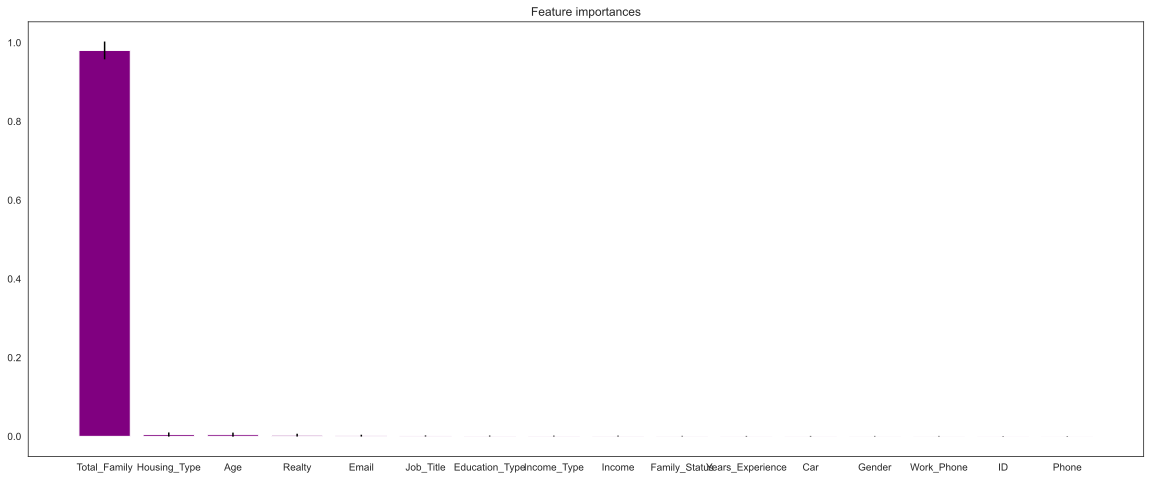

In [58]:
#Plotting Feature Importances
print('Feature importance ranking\n\n')
importances = rand_f.feature_importances_
std = np.std([tree.feature_importances_ for tree in rand_f.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
variables = df.columns
importance_list = []
for f in range(X.shape[1]):
    variable = variables[indices[f]]
    importance_list.append(variable)
    print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))
plt.figure(figsize=(20, 8))
plt.title("Feature importances")
plt.bar(importance_list, importances[indices],
       color="purple", yerr=std[indices], align='center')